# Import StreamPoseML

In [65]:
%%capture
%pip install stream_pose_ml

# Set input and output directories

In [66]:
import os
import time

# Inputs
example_input_directory = "../../example_data/input"
example_output_directory = f"../../example_data/output-{time.time_ns()}"

source_annotations_directory = os.path.join(example_input_directory, "source_annotations")
source_videos_directory = os.path.join(example_input_directory, "source_videos")

# Outputs

# The location to output sequence data
sequence_data_directory = os.path.join(example_output_directory, "sequences")

# The location to output keypoint data
keypoints_data_directory = os.path.join(example_output_directory, "keypoints")

# The location to output datasets
merged_annotation_output_directory = os.path.join(example_output_directory, "datasets")

for dir in [sequence_data_directory, keypoints_data_directory, merged_annotation_output_directory]:
    os.makedirs(dir, exist_ok=True)

# Generate Keypoints and Sequence Data

In [67]:

import stream_pose_ml.jobs.process_videos_job as pv

folder = f"run-preproccessed-{time.time_ns()}"  
keypoints_path = f"{keypoints_data_directory}/{folder}"
sequence_path = f"{sequence_data_directory}/{folder}"

data = pv.ProcessVideosJob().process_videos(
    src_videos_path=source_videos_directory,
    output_keypoints_data_path=keypoints_path,
    output_sequence_data_path=sequence_path,
    write_keypoints_to_file=True,
    write_serialized_sequence_to_file=True,
    limit=None,
    configuration={},
    preprocess_video=True,
    return_output=False
)

print(f"Generated keypoints are located at {data['keypoints_path']}")
print(f"Generated sequences are located at {data['sequence_path']}")

Successfully wrote ../../example_data/output-1714084427248021000/sequences/run-preproccessed-1714084429928530000/example_video.webm_sequence.json.
1/1 completed: example_video.webm.
Generated keypoints are located at ../../example_data/output-1714084427248021000/keypoints/run-preproccessed-1714084429928530000
Generated sequences are located at ../../example_data/output-1714084427248021000/sequences/run-preproccessed-1714084429928530000


# Merge video sequence data into a dataset

In [68]:
import stream_pose_ml.jobs.build_and_format_dataset_job as data_builder 

db = data_builder.BuildAndFormatDatasetJob()

dataset_file_name = "preprocessed_flatten_on_example_10_frames_5"

dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="flatten_into_columns",
    segmentation_splitter_label="step_type",
    segmentation_window=10,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename=dataset_file_name
)


True

# Train a model (Gradient Boost)

In [69]:
# Our dataset example is comically small, so let's make it bigger for the sake of a training demonstration

import pandas as pd
data_file = os.path.join(merged_annotation_output_directory, f"{dataset_file_name}.csv")
data_file_expanded = os.path.join(merged_annotation_output_directory, f"{dataset_file_name}-EXPANDED.csv")

df = pd.read_csv(data_file)
df = pd.concat( map(pd.read_csv, [data_file for _ in range(100)]), ignore_index=True) 
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv(data_file_expanded)


Training Balance for weight_transfer_type:
0    1440
1    1440
Name: weight_transfer_type, dtype: int64


11657.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11657.39s - pydevd: Sending message rela

Mean ROC AUC from cross validation: 1.000
Min ROC AUC from cross validation: 1.000
Max ROC AUC from cross validation: 1.000
Classification Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Matthews correlation coefficient (-1 to 1): 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       360

    accuracy                           1.00       460
   macro avg       1.00      1.00      1.00       460
weighted avg       1.00      1.00      1.00       460



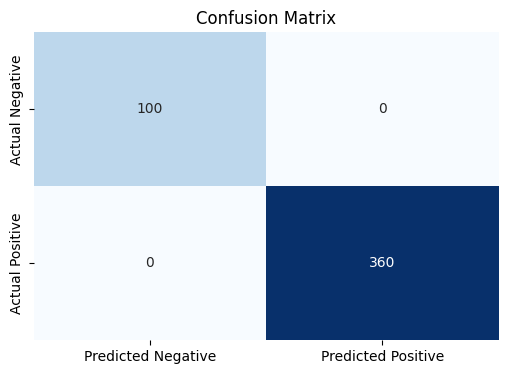

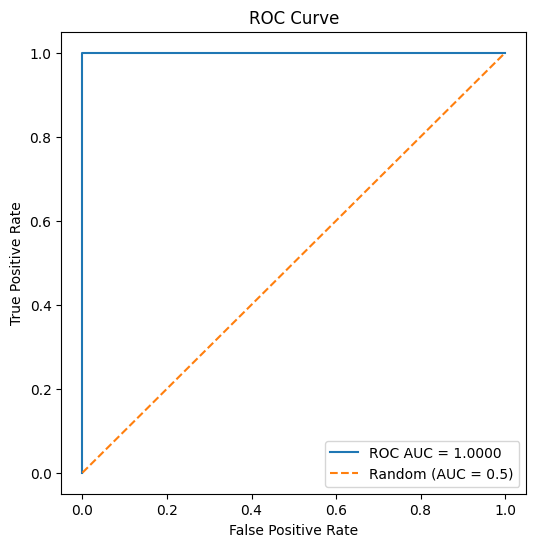

In [70]:
# NOTE This example will be very overfit!
from stream_pose_ml.learning import model_builder as mb

# Mapping string categories to numerical
value_map = {
    "weight_transfer_type": {
        "Failure Weight Transfer": 0,
        "Successful Weight Transfer": 1,
    },
    "step_type": {
        "Left Step": 0,
        "Right Step": 1,
    },
}
# Columns we know we'll always want to drop
drop_list = ["video_id", "step_frame_id", "frame_number", "step_type"]
# Only keep these columns (including target)
column_whitelist = []


model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file_expanded,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.train_gradient_boost()
model_builder.evaluate_model()

# Train a model (Random Forest)

Training Balance for weight_transfer_type:
0    1440
1    1440
Name: weight_transfer_type, dtype: int64


/opt/homebrew/Caskroom/miniconda/base/envs/poser/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best random search hyperparameters: {'n_estimators': 449, 'max_features': 8, 'max_depth': 14}
Mean ROC AUC from cross validation: 1.000
Min ROC AUC from cross validation: 1.000
Max ROC AUC from cross validation: 1.000
Top 5 features
{'angles.frame-1-left_knee_left_ankle_to_left_ankle_left_foot_index.angle_2d_degrees': '1.4061266034237307%'}
{'distances.frame-2-right_knee_to_plumb_line.distance_2d': '1.2710805122638384%'}
{'distances.frame-7-left_knee_to_plumb_line.distance_2d_normalized': '1.259496676814943%'}
{'angles.frame-2-left_knee_left_ankle_to_left_ankle_left_foot_index.angle_2d_degrees': '1.1135857461024499%'}
{'distances.frame-7-left_foot_index_to_plumb_line.distance_2d_normalized': '1.0674615703839654%'}
Classification Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Matthews correlation coefficient (-1 to 1): 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

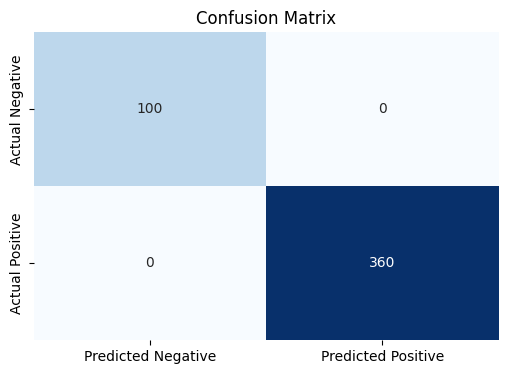

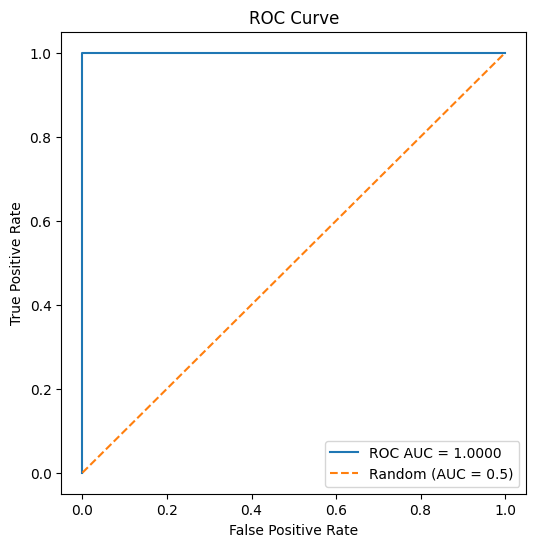

In [71]:
from random import randint
# NOTE This example will be very overfit!
from stream_pose_ml.learning import model_builder as mb

# Mapping string categories to numerical
value_map = {
    "weight_transfer_type": {
        "Failure Weight Transfer": 0,
        "Successful Weight Transfer": 1,
    },
    "step_type": {
        "Left Step": 0,
        "Right Step": 1,
    },
}
# Columns we know we'll always want to drop
drop_list = ["video_id", "step_frame_id", "frame_number", "step_type"]
# Only keep these columns (including target)
column_whitelist = []

model_builder.load_and_prep_dataset_from_csv(
    path=data_file_expanded,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
# model_builder.run_pca(num_components=200)

param_dist = {
    "n_estimators": [randint(400, 600)],
    "max_depth": [randint(9, 15)],
    "max_features": [randint(4, 12)],
}
rf_params = {
    "n_estimators": [20,50,100,200],
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=True, 
    params=rf_params, 
    param_dist=param_dist, 
    iterations=50, 
    random_state = 123
)
model_builder.evaluate_model()

# Save model for use in the Web Application

Will be saved to data/trained_models

In [72]:
""" WRITE NOTES ON THIS RUN HERE """
notes = """
Gradient Boost classifier (90% ROC AUC) trained on dataset preprocessed_flatten_on_example_10_frames, a 10 frame window with flat column 2d angles + distances, and randomly upsampled
    """

model_builder.save_model_and_datasets(notes=notes, model_type="gradient-boost")

Saved model to pickle! ../../data/trained_models/Random Forest-1714084586666480000.pickle


# Other kinds of datasets from sequences

### Dataset with raw x, y, z joint data, with one frame per row

In [73]:
sequence_data_directory = "../../data/sequences/run-preproccessed-1680117203184086000"
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_joints=True,
    include_z_axis=True,
    include_angles=False,
    include_distances=False,
    include_normalized=False,
    segmentation_strategy="none",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="preprocessed_frame_joint_data"
)

True

### Split on Step Type, pooled temporal dynamics with angles and distances, only the last 10 frames

In [74]:
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=True,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="split_on_label",
    segmentation_splitter_label="step_type",
    segmentation_window=10,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="pooled_angles_distances_last_10_frames"
)

True

### Flatten columns over 10 frame window on step type (arbitrary start / end)

In [75]:
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=True,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="split_on_label",
    segmentation_splitter_label="step_type",
    segmentation_window=10,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="pooled_angles_distances_last_10_frames"
)

True

### Flatten on a 10 frame window based on complete training examples (the end of the example will flatten the previous 10 frames into a training row0)

In [76]:
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="flatten_on_example",
    segmentation_splitter_label="step_type",
    segmentation_window=10,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="flatten_on_example_10_frames_2"
)

True

### Flatten on a 25 frame window based on complete training examples (the end of the example will flatten the previous 25 frames into a training row)

In [77]:
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="flatten_on_example",
    segmentation_splitter_label="step_type",
    segmentation_window=25,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="preprocessed_flatten_on_example_25_frames_2"
)

True

### Dataset with all frames as rows

In [78]:
db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="none",
    segmentation_splitter_label="step_type",
    segmentation_window=25,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="preprocessed_all_rows.csv",
)

True